# Kernel ridge regression

Let $\varphi$ be a function, that maps the input data $x_1, \ldots, x_n \in \mathbb{R}^d$ to some finite or infinite dimensional $\mathbb{R}$-vector space (so-called *feature space*). The *representer theorem* states that if a function $k: \mathbb{R}^d \times \mathbb{R}^d \to \mathbb R$ is a *valid kernel*, then it defines the scalar product of the input data in that feature space
$$ k(x, x') \; = \; \langle \varphi(x), \varphi(x') \rangle \; \; \; \; \; \text{for all} \; \;  x, x' \in \mathbb{R}^d$$
The function $k$ is a *valid kernel*, iff it satisfies the *Mercer's condition*, which verifies that for any input data $x_1, \ldots, x_n \in \mathbb{R}^d$ and coefficients $c_1, \ldots, c_n \in \mathbb{R}$ the inequality 
$$ \sum_{i=1}^{n} \sum_{j=1}^n c_i c_j k(x_i, x_j) \geq 0 $$
is satisfied.

We will predict two dimensional hand positions $y \in \mathbb{R}^2$ from electromyographic (EMG) recordings $x \in \mathbb{R}^{192}$ obtained with high-density electrode arrays on the lower arm.     
Labels are 2D positions of the hand during different hand movements.

Remember that even after 'linearizing' the EMG-hand position relationship by computing the log of the EMG features, the relationship is not exactly linear. Also we do not know the exact non-linearity; it might not be the same for all regions in EMG space and for all electrodes. So we can hope to gain something from using a non-parametric and non-linear method like kernel ridge regression.

The criterion to evaluate the model and select optimal parameters is the so called coefficient of determination, or $r^2$ index
$$ r^2 = 1-\frac{\sum_{d=1}^D \mathbb{V}(\hat{y}_d-y_d)}{\sum_{d=1}^D \mathbb{V}(y_d)} $$
where $D$ is the dimensionality of the data labels, $y$ are the true labels and $\hat{y}$ the estimated labels. This score is 1 for perfect predictions and smaller otherwise.

We use the dataset ```myo_data.mat``` .

In [1]:
import pylab as pl
import scipy as sp
from numpy.linalg import inv
from numpy.linalg import solve
from scipy.io import loadmat
import numpy as np
from scipy.spatial.distance import cdist
%matplotlib inline

We implement Kernel Ridge Regression (KRR) with the functions  ```krr_train``` and  ```krr_apply```. 
Notation is:

$$ X_{\text{train}} \in \mathbb{R}^{D_X \times N_{tr}}, \;  Y_{\text{train}} \in \mathbb{R}^{D_Y \times N_{tr}}, \; X_{\text{test}} \in \mathbb{R}^{D_X \times N_{te}} $$
In ```krr_train```, we estimate a linear combination of the input vectors $\alpha$, 
$$\alpha = (K + \lambda I)^{-1}Y_{\text{train}}^T$$
where $\lambda$ is the regularization parameter and $K$ is the $N_{tr} \times N_{tr}$ Gaussian Kernel matrix with Kernel width $\sigma$, $K_{ij} =  \exp\left( - \frac{\| X_{\text{train}}^i - X_{\text{train}}^j\|^2}{\sigma^2} \right)$.

The function ```krr_apply``` then uses the weights $\alpha$ to predict the (unknown) hand positions of new test data $X_{\text{test}}$
$$ Y_{\text{test}} = (\mathbf{k} \alpha)^T.$$
where $\mathbf k$ is the $N_{\text{test}} \times N_{\text{train}}$ matrix $\mathbf{k}_{ij} =   \exp\left( - \frac{\| X_{\text{test}}^i - X_{\text{train}}^j\|^2}{\sigma^2}\right) $.    

The function  ```test_sine_toydata``` helps debug the code. It generates toy data that follows a sine function, $x_i \in \{0, 0.01, 0.02, \ldots, 10\}, y_i = \sin(x_i) + \epsilon, \epsilon \sim \mathcal{N}(0, 0.5)$.

In [23]:
def load_data(fname):
    ''' Loads EMG data from <fname> '''
    # load the data
    data = loadmat(fname)
    # extract data for training
    X_train = data['training_data']
    X_train = sp.log(X_train)
    X_train = X_train[:, :1000]
    # extract hand positions
    Y_train = data['training_labels']
    Y_train = Y_train[:, :1000]
    return X_train,Y_train

def GaussianKernel(X1, X2, kwidth):
    ''' Compute Gaussian Kernel 
    Input: X1    - DxN1 array of N1 data points with D features 
           X2    - DxN2 array of N2 data points with D features 
           kwidth - Kernel width
    Output K     - N1 x N2 Kernel matrix
    '''
    assert(X1.shape[0] == X2.shape[0])
    K = cdist(X1.T, X2.T, 'euclidean')
    K = np.exp(-(K ** 2) / (2. * kwidth ** 2))
    return K

def train_krr(X_train, Y_train,kwidth,llambda):
    ''' Trains kernel ridge regression (krr)
    Input:       X_train  -  DxN array of N data points with D features
                 Y        -  D2xN array of length N with D2 multiple labels
                 kwdith   -  kernel width
                 llambda    -  regularization parameter
    Output:      alphas   -  NxD2 array, weighting of training data used for apply_krr                     
    '''
    
    K = GaussianKernel(X_train,X_train,kwidth)
    L = llambda * np.identity(K.shape[0])
    alphas = np.dot(np.linalg.inv(K-L), Y_train.T)
    
    return alphas
    
    
def apply_krr(alphas, X_train, X_test, kwidth):
    ''' Applys kernel ridge regression (krr)
    Input:      alphas      -  NtrxD2 array trained in train_krr      
                X_train     -  DxNtr array of Ntr train data points with D features
                X_test      -  DxNte array of Nte test data points with D features
                kwidht      -  Kernel width             
    Output:     Y_test      -  D2xNte array
    '''
    
    k = GaussianKernel(X_test,X_train,kwidth)
    Y_test  = (np.dot(k,alphas)).T
    
    return Y_test

def train_ols(X_train, Y_train):
    ''' Trains ordinary least squares (ols) regression 
    Input:       X_train  -  DxN array of N data points with D features
                 Y        -  D2xN array of length N with D2 multiple labels
    Output:      W        -  DxD2 array, linear mapping used to estimate labels 
                             with sp.dot(W.T, X)                      
    '''
    #W = sp.dot(inv(sp.dot(X_train,X_train.T)),sp.dot(X_train,Y_train.T))
    W = solve(sp.dot(X_train,X_train.T),sp.dot(X_train,Y_train.T))
    return W
    
def apply_ols(W, X_test):
    ''' Applys ordinary least squares (ols) regression 
    Input:       X_test    -  DxN array of N data points with D features
                 W        -  DxD2 array, linear mapping used to estimate labels 
                             trained with train_ols                   
    Output:     Y_test    -  D2xN array
    '''
    Y_test = sp.dot(W.T, X_test)
    return Y_test

def test_handpositions():
    X,Y = load_data('myo_data.mat')
    crossvalidate_krr(X,Y)

def test_sine_toydata(kwidth = 1, llambda = 1):
    #Data generation
    X_train = sp.arange(0,10,.01)
    X_train = X_train[None,:]
    Y_train = sp.sin(X_train) + sp.random.normal(0,.5,X_train.shape)
    #Linear Regression 
    w_est = train_ols(X_train, Y_train) 
    Y_est_lin = apply_ols(w_est,X_train)
    #Kernel Ridge Regression
    alphas = train_krr(X_train,Y_train,kwidth,llambda)
    Y_est_krr = apply_krr(alphas,X_train,X_train,kwidth)
    
    #Plot result
    pl.figure()
    pl.plot(X_train.T, Y_train.T, '+k', label = 'Train Data')
    pl.plot(X_train.T, Y_est_lin.T, '-.', linewidth = 2, label = 'OLS')
    pl.plot(X_train.T, Y_est_krr.T,  'r', linewidth = 2, label = 'KRR')
    pl.xlabel('x')
    pl.ylabel('y')
    pl.title(r'$\lambda$ = ' + str(llambda) + '   $\sigma$ = ' + str(kwidth))
    pl.legend(loc = 'lower right')
    
      
def crossvalidate_krr(X,Y,f=5, kwidths=10.0**np.array([0, 1, 2]), llambdas=10.0**np.array([-4, -2, 0])):
    ''' 
    Test generalization performance of kernel ridge regression with gaussian kernel
    Input:      X   data (dims-by-samples)
                Y   labels (dims2-by-samples)
                f   number of cross-validation folds
                kwidths width of gaussian kernel function 
                llambdas regularizer (height of ridge on kernel matrix)
    '''
    N = int(f*(X.shape[-1]/f))
    print(f)
    idx = sp.reshape(sp.random.permutation(sp.arange(N)),(f,int(N/f)))
    r2_outer = sp.zeros((f))
    r2_linear = sp.zeros((f))
    r2_inner = sp.zeros((f-1,kwidths.shape[-1],llambdas.shape[-1]))
    
    # to outer cross-validation (model evaluation)
    for ofold in range(f):
        # split in training and test (outer fold)
        otestidx = sp.zeros((f),dtype=bool)
        otestidx[ofold] = 1
        otest = idx[otestidx,:].flatten()
        otrain = idx[~otestidx,:]
        
        # inner cross-validation (model selection)
        for ifold in range(f-1):
            # split in training and test (inner fold)
            itestidx = sp.zeros((f-1),dtype=bool)
            itestidx[ifold] = 1
            itest = otrain[itestidx,:].flatten()
            itrain = otrain[~itestidx,:].flatten()
            
            # do inner cross-validation (model selection)
            for illambda in range(llambdas.shape[-1]):
                for ikwidth in range(kwidths.shape[-1]):
                    #compute kernel for all data points
                    alphas = train_krr(X[:,itrain],Y[:,itrain],kwidths[ikwidth],llambdas[illambda])
                    yhat = apply_krr(alphas, X[:,itrain], X[:,itest],kwidths[ikwidth])
                    r2_inner[ifold,ikwidth,illambda] = compute_rsquare(yhat,Y[:,itest])

        #train again using optimal parameters
        r2_across_folds = r2_inner.mean(axis=0)
        optkwidthidx, optllambdaidx = np.unravel_index(r2_across_folds.flatten().argmax(),r2_across_folds.shape)
        #evaluate model on outer test fold
        alphas = train_krr(X[:,otrain.flatten()],Y[:,otrain.flatten()], kwidths[optkwidthidx],llambdas[optllambdaidx])
        yhat = apply_krr(alphas, X[:,otrain.flatten()],X[:,otest], kwidths[optkwidthidx])
        r2_outer[ofold] = compute_rsquare(yhat,Y[:,otest])

        # for comparison: predict with linear model
        w_est = train_ols(X[:,otrain.flatten()], Y[:,otrain.flatten()]) 
        y_est_lin = apply_ols(w_est,X[:,otest])
        r2_linear[ofold] = compute_rsquare(y_est_lin,Y[:,otest])
        
        print('Fold %d'%ofold + ' best kernel width %f'%kwidths[optkwidthidx] +\
        ' best regularizer %f'%llambdas[optllambdaidx] + \
        ' rsquare %f'%r2_outer[ofold] + \
        ' rsquare linear %f'%r2_linear[ofold])
    pl.figure()
    pl.boxplot(sp.vstack((r2_outer,r2_linear)).T)
    pl.ylabel('$r^2$')
    pl.xticks((1,2),('KRR','Lin'))
    #pl.savefig('krr_vs_lin_comparison.pdf')
    return r2_outer,r2_linear
    
def compute_rsquare(yhat,Y):
    '''compute coefficient of determination'''
    return 1 - (sp.var((yhat - Y),axis=1).sum()/sp.var(Y,axis=1).sum())

Testing our implementation of KRR with sine-shaped toydata. We also compare it to Ordinary-Least-Squares regresssion. Note the effects of different hyper-parameter values.

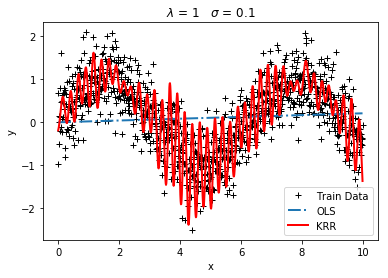

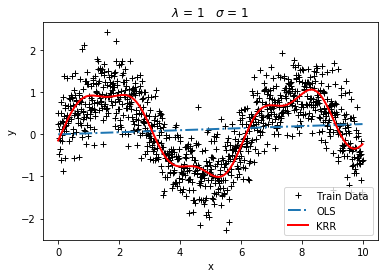

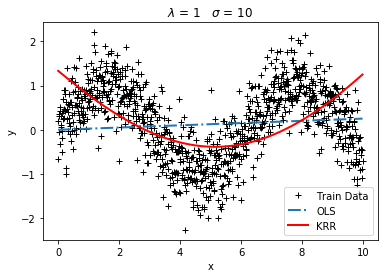

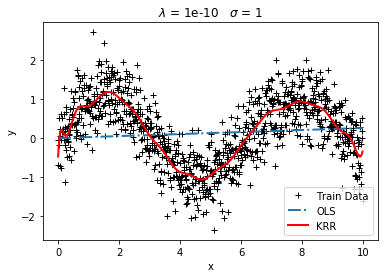

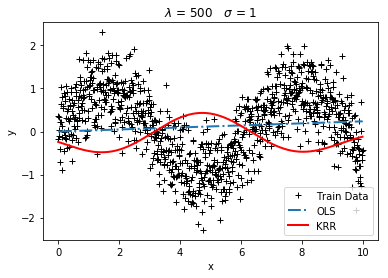

In [9]:
test_sine_toydata(llambda = 1, kwidth = 0.1)
test_sine_toydata(llambda = 1, kwidth = 1)
test_sine_toydata(llambda = 1, kwidth = 10)
test_sine_toydata(llambda = 1e-10, kwidth = 1)
test_sine_toydata(llambda = 500, kwidth = 1)

Now, we predict handpositions from our dataset ```myo_data.mat```. To find the best hyper-parameters we use nested cross-validation. Again, we compare our kernel-regression with OLS-regression.

5
Fold 0 best kernel width 10.000000 best regularizer 0.000100 rsquare 0.962163 rsquare linear 0.921244
Fold 1 best kernel width 10.000000 best regularizer 0.000100 rsquare 0.960869 rsquare linear 0.923086
Fold 2 best kernel width 10.000000 best regularizer 0.000100 rsquare 0.951601 rsquare linear 0.932113
Fold 3 best kernel width 10.000000 best regularizer 0.000100 rsquare 0.956849 rsquare linear 0.909460
Fold 4 best kernel width 10.000000 best regularizer 0.000100 rsquare 0.959041 rsquare linear 0.920612


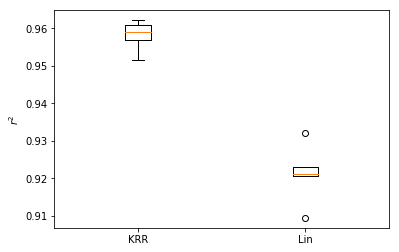

In [24]:
test_handpositions()